## Import Dependencies in Python

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
get_ipython().run_line_magic('matplotlib', 'inline')
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import datetime
import quandl
from plotnine import *
from statsmodels.tsa.vector_ar.var_model import VAR
import math 

## Step 1) Import daily data

In [2]:
df = pd.read_csv('daily_data.csv')
df = df.rename(columns={"Unnamed: 0": "date"})
df.set_index('date')
df.index = pd.to_datetime(df['date'],yearfirst=True)
df['date'] = pd.to_datetime(df['date'],yearfirst=True)
df

,date,WTI,BRENT,exxon_close,chevron_close,conoco_close,eog_close,valero_close,baker_close,WTI_increase,...,chevron_increase,chevron_decrease,conoco_increase,conoco_decrease,eog_increase,eog_decrease,valero_increase,valero_decrease,baker_increase,baker_decrease
date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,1990-01-02,22.88,21.20,12.500000,17.281250,9.767180,3.046875,3.456353,25.875000,0,...,0,0,0,0,0,0,0,0,0,0
1990-01-03,1990-01-03,23.81,22.65,12.375000,17.000000,9.576602,3.031250,3.513483,25.500000,1,...,0,1,0,1,0,1,1,0,0,1
1990-01-04,1990-01-04,23.41,22.50,12.250000,16.781250,9.386023,2.953125,3.570612,24.875000,0,...,0,1,0,1,0,1,1,0,0,1
1990-01-05,1990-01-05,23.07,23.13,12.187500,16.531250,9.290733,2.906250,3.599177,24.750000,0,...,0,1,0,1,0,1,1,0,0,1
1990-01-08,1990-01-08,21.64,21.38,12.375000,16.687500,9.481312,2.859375,3.542048,25.000000,0,...,1,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,2020-05-22,33.49,33.80,44.599998,90.279999,43.279999,52.279999,65.680000,15.120000,0,...,0,1,0,1,0,1,0,1,0,1
2020-05-26,2020-05-26,34.70,33.95,45.910000,93.300003,43.669998,51.439999,68.699997,16.010000,1,...,1,0,1,0,0,1,1,0,1,0
2020-05-27,2020-05-27,32.80,32.73,46.240002,93.900002,44.669998,52.730000,70.180000,16.559999,0,...,1,0,1,0,1,0,1,0,1,0


In [3]:
display(list(df.columns.values)) 

['date',
 'WTI',
 'BRENT',
 'exxon_close',
 'chevron_close',
 'conoco_close',
 'eog_close',
 'valero_close',
 'baker_close',
 'WTI_increase',
 'WTI_decrease',
 'BRENT_increase',
 'BRENT_decrease',
 'exxon_increase',
 'exxon_decrease',
 'chevron_increase',
 'chevron_decrease',
 'conoco_increase',
 'conoco_decrease',
 'eog_increase',
 'eog_decrease',
 'valero_increase',
 'valero_decrease',
 'baker_increase',
 'baker_decrease']

In [4]:
WTI_ts=df[['WTI','WTI_increase',
 'exxon_increase',
 'chevron_increase',
 'conoco_increase',
 'eog_increase',
 'valero_increase',
 'baker_increase']]
BRENT_ts=df[['BRENT','BRENT_increase',
 'exxon_increase',
 'chevron_increase',
 'conoco_increase',
 'eog_increase',
 'valero_increase',
 'baker_increase']]

# Step 2) Spliting the datasets into training and test datasets 

In [5]:
split_date = pd.datetime(2019,1,1)
WTI_train = WTI_ts.loc[WTI_ts.index < split_date]
WTI_test = WTI_ts.loc[WTI_ts.index >= split_date]
BRENT_train = BRENT_ts.loc[BRENT_ts.index < split_date]
BRENT_test = BRENT_ts.loc[BRENT_ts.index >= split_date]
WTI_test

,WTI,WTI_increase,exxon_increase,chevron_increase,conoco_increase,eog_increase,valero_increase,baker_increase
date,,,,,,,,
2019-01-02,46.31,1,1,1,1,1,1,0
2019-01-03,46.92,1,0,0,0,0,0,0
2019-01-04,47.76,1,1,1,1,1,1,1
2019-01-07,48.27,1,1,1,0,1,1,1
2019-01-08,49.58,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...
2020-05-22,33.49,0,1,0,0,0,0,0
2020-05-26,34.70,1,1,1,1,0,1,1
2020-05-27,32.80,0,1,1,1,1,1,1


In [12]:
WTI_train

,WTI,WTI_increase,exxon_increase,chevron_increase,conoco_increase,eog_increase,valero_increase,baker_increase
date,,,,,,,,
1990-01-02,22.88,0,0,0,0,0,0,0
1990-01-03,23.81,1,0,0,0,0,1,0
1990-01-04,23.41,0,0,0,0,0,1,0
1990-01-05,23.07,0,0,0,0,0,1,0
1990-01-08,21.64,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...
2018-12-19,47.96,1,0,0,0,0,0,0
2018-12-20,45.64,0,0,0,0,0,0,0
2018-12-21,45.38,0,0,0,0,0,1,1


# Step 3: Running Multivariate Time Series Vector Auto Regression on WTI and BRENT

In [7]:
WTI_model=sm.tsa.ARIMA(endog=WTI_train['WTI'],exog=WTI_train[['WTI_increase','exxon_increase',
                                                              'chevron_increase','conoco_increase','eog_increase', 
                                                              'valero_increase','baker_increase']],order=[0,1,2])
WTI_model_fit= WTI_model.fit()
print(WTI_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.WTI   No. Observations:                 7217
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -9586.720
Method:                       css-mle   S.D. of innovations              0.913
Date:                Thu, 19 Nov 2020   AIC                          19195.440
Time:                        20:58:04   BIC                          19271.166
Sample:                             1   HQIC                         19221.494
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0228      0.019    -52.633      0.000      -1.061      -0.985
WTI_increase         1.3955      0.023     61.475      0.000       1.351       1.440
exxon_increase       0.0541 

In [32]:
sm.tsa.ARIMA?

Init signature:
sm.tsa.ARIMA(
    endog,
    order,
    exog=None,
    dates=None,
    freq=None,
    missing='none',
)
Docstring:     
Autoregressive Integrated Moving Average ARIMA(p,d,q) Model

Parameters
----------
endog : array_like
    The endogenous variable.
order : iterable
    The (p,d,q) order of the model for the number of AR parameters,
    differences, and MA parameters to use.
exog : array_like, optional
    An optional array of exogenous variables. This should *not* include a
    constant or trend. You can specify this in the `fit` method.
dates : array_like, optional
    An array-like object of datetime objects. If a pandas object is given
    for endog or exog, it is assumed to have a DateIndex.
freq : str, optional
    The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
    'M', 'A', or 'Q'. This is optional if dates are given.


Notes
-----
If exogenous variables are given, then the model that is fit is

.. math::

   \phi(L)(y_t - X_t\beta) = \theta

In [24]:
train_end_date=pd.datetime(2018,12,31)
test_end_date=pd.datetime(2020, 6, 1)

train_end_date

datetime.datetime(2018, 12, 31, 0, 0)

In [70]:
# setting dates for the prediction index
start_date= WTI_test.index[0]
end_date= WTI_test.index[7218]
end_date

Timestamp('2020-05-29 00:00:00')

In [89]:
WTI_index=WTI_ts['WTI'].index[7218:]

In [90]:
WTI_index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='date', length=351, freq=None)

## WTI_prediction = WTI_model_fit.predict(exog=WTI_test['WTI'],typ='linear',dynamic=False)

In [109]:
WTI_predictions=WTI_model_fit.predict(start=7218,end=7568,exog=WTI_test[['WTI_increase','exxon_increase',
                                                              'chevron_increase','conoco_increase','eog_increase', 
                                                              'valero_increase','baker_increase']],typ='linear',dynamic=False)
WTI_predictions = pd.DataFrame(WTI_predictions,index=WTI_index.index)
WTI_predictions

AttributeError: 'DatetimeIndex' object has no attribute 'index'

In [105]:
WTI_predictions = pd.DataFrame(WTI_predictions,index=WTI_index.index)
WTI_predictions

AttributeError: 'DatetimeIndex' object has no attribute 'index'

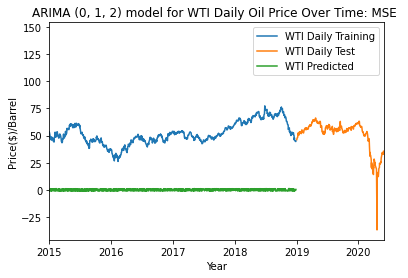

In [106]:
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.plot(WTI_train["WTI"],label="WTI Daily Training")
plt.plot(WTI_test["WTI"],label="WTI Daily Test")
plt.plot(WTI_prediction,label="WTI Predicted")

plt.title(f'ARIMA (0, 1, 2) model for WTI Daily Oil Price Over Time: MSE ')
plt.legend(loc = 'Left corner')
plt.show()

In [ ]:
print(f'The Model fit for the ARIMA model using the daily WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_ARIMA_MSE}')


In [ ]:
#Obtain the ARIMA model's predicted values and 95% CI from 2019 to 2020

BRENT_prediction, BRENT_confint = BRENT_arima_model.predict(n_periods = 351, return_conf_int=True)
BRENT_prediction = pd.DataFrame(BRENT_prediction,index=BRENT_test.index)
BRENT_prediction.columns = ['BRENT_predicted_oil_price']
BRENT_lower_series = pd.Series(BRENT_confint[:, 0], index=WTI_test.index)
BRENT_upper_series = pd.Series(BRENT_confint[:, 1], index=WTI_test.index)

#Calculate the model fit and accuracy scores of ARIMA model for predicitng WTI test data from 2019 to 2020

BRENT_accuracy = metrics.r2_score(BRENT_test, BRENT_prediction)
BRENT_ARIMA_MSE = metrics.mean_squared_error(BRENT_test, BRENT_prediction)

In [ ]:
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train,label="BRENT Daily Training")
plt.plot(BRENT_test,label="BRENT Daily Test")
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.plot(BRENT_prediction,label="BRENT Daily Predicted")
plt.fill_between(BRENT_lower_series.index, 
                     BRENT_lower_series, 
                     BRENT_upper_series, 
                     alpha=0.25, label='95%CI')
plt.title(f'ARIMA (1, 1, 0) model for BRENT Daily Oil Price Over Time: MSE = {BRENT_ARIMA_MSE}')
plt.legend(loc = 'Left corner')
plt.show()